### For the prediction data file (predict_sku1.csv), perform demand forecasting analysis using a Gradient Boosting Tree model at daily, weekly, and monthly time granularities.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

##### The data that needs to be predicted contains some product codes that are not present in the original dataset and therefore cannot be used for prediction. Only the parts of the dataset that have the product codes will be analyzed.

##### Subsequently, the predicted results will be replaced by the average values grouped by 'sales_region_code', 'first_cate_code', and 'second_cate_code'.

In [2]:
df1 = pd.read_csv(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\order_train1.csv', encoding='gbk')
df2 = pd.read_csv(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\predict_sku1.csv', encoding='gbk')

data = df1[df1[['sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code']].apply(tuple, axis=1).isin(
    df2[['sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code']].apply(tuple, axis=1))]

In [3]:
# Data Preparation
# Remove outliers from the 'ord_qty' column

def remove_outliers(df, col_name):
   q1 = df[col_name].quantile(0.25)
   q3 = df[col_name].quantile(0.75)
   iqr = q3 - q1
   lower_bound = q1 - 1.5 * iqr
   upper_bound = q3 + 1.5 * iqr
   df = df[(df[col_name] >= lower_bound) & (df[col_name] <= upper_bound)]
   return df

data_without_outliers = remove_outliers(data, 'ord_qty')
# Boxplot before and after removing outliers

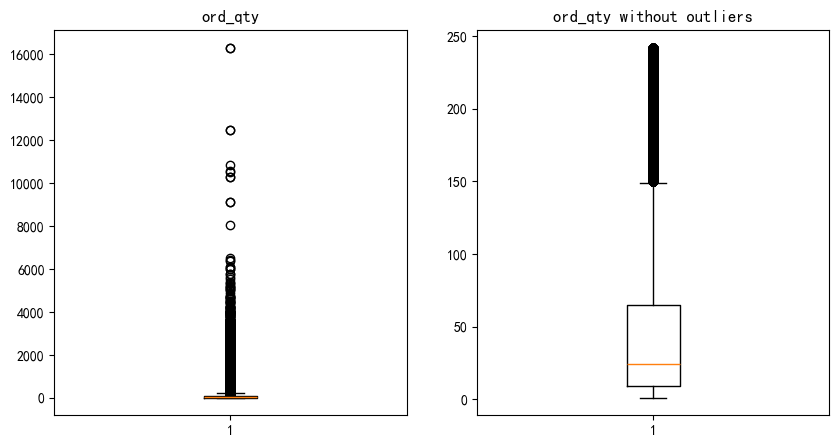

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].boxplot(data['ord_qty'])
axs[0].set_title('ord_qty')
axs[1].boxplot(data_without_outliers['ord_qty'])
axs[1].set_title('ord_qty without outliers')
plt.show()

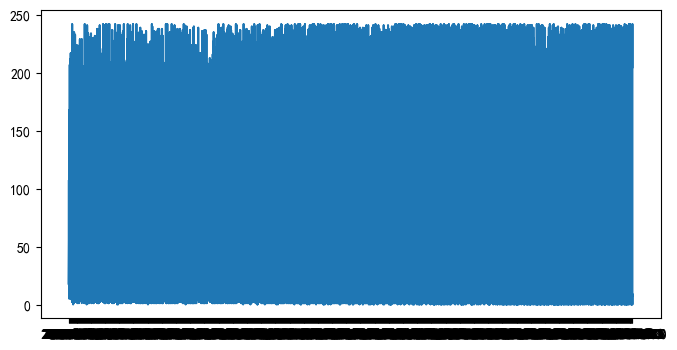

In [5]:
# Graph of Demand
data_without_outliers.index = pd.to_datetime(data_without_outliers.index)
plt.figure(figsize=(8,4))
plt.plot(data_without_outliers['order_date'],data_without_outliers['ord_qty'])
plt.show()

##### It is obvious that such a large volume of data and images are not conducive to the upcoming analysis. In conjunction with question two, the data will be resampled by day, week, and month.

In [6]:
data_without_outliers = data.copy()
data_without_outliers['order_date'] = pd.to_datetime(
    data_without_outliers['order_date'])
data_without_outliers = data_without_outliers.set_index('order_date')

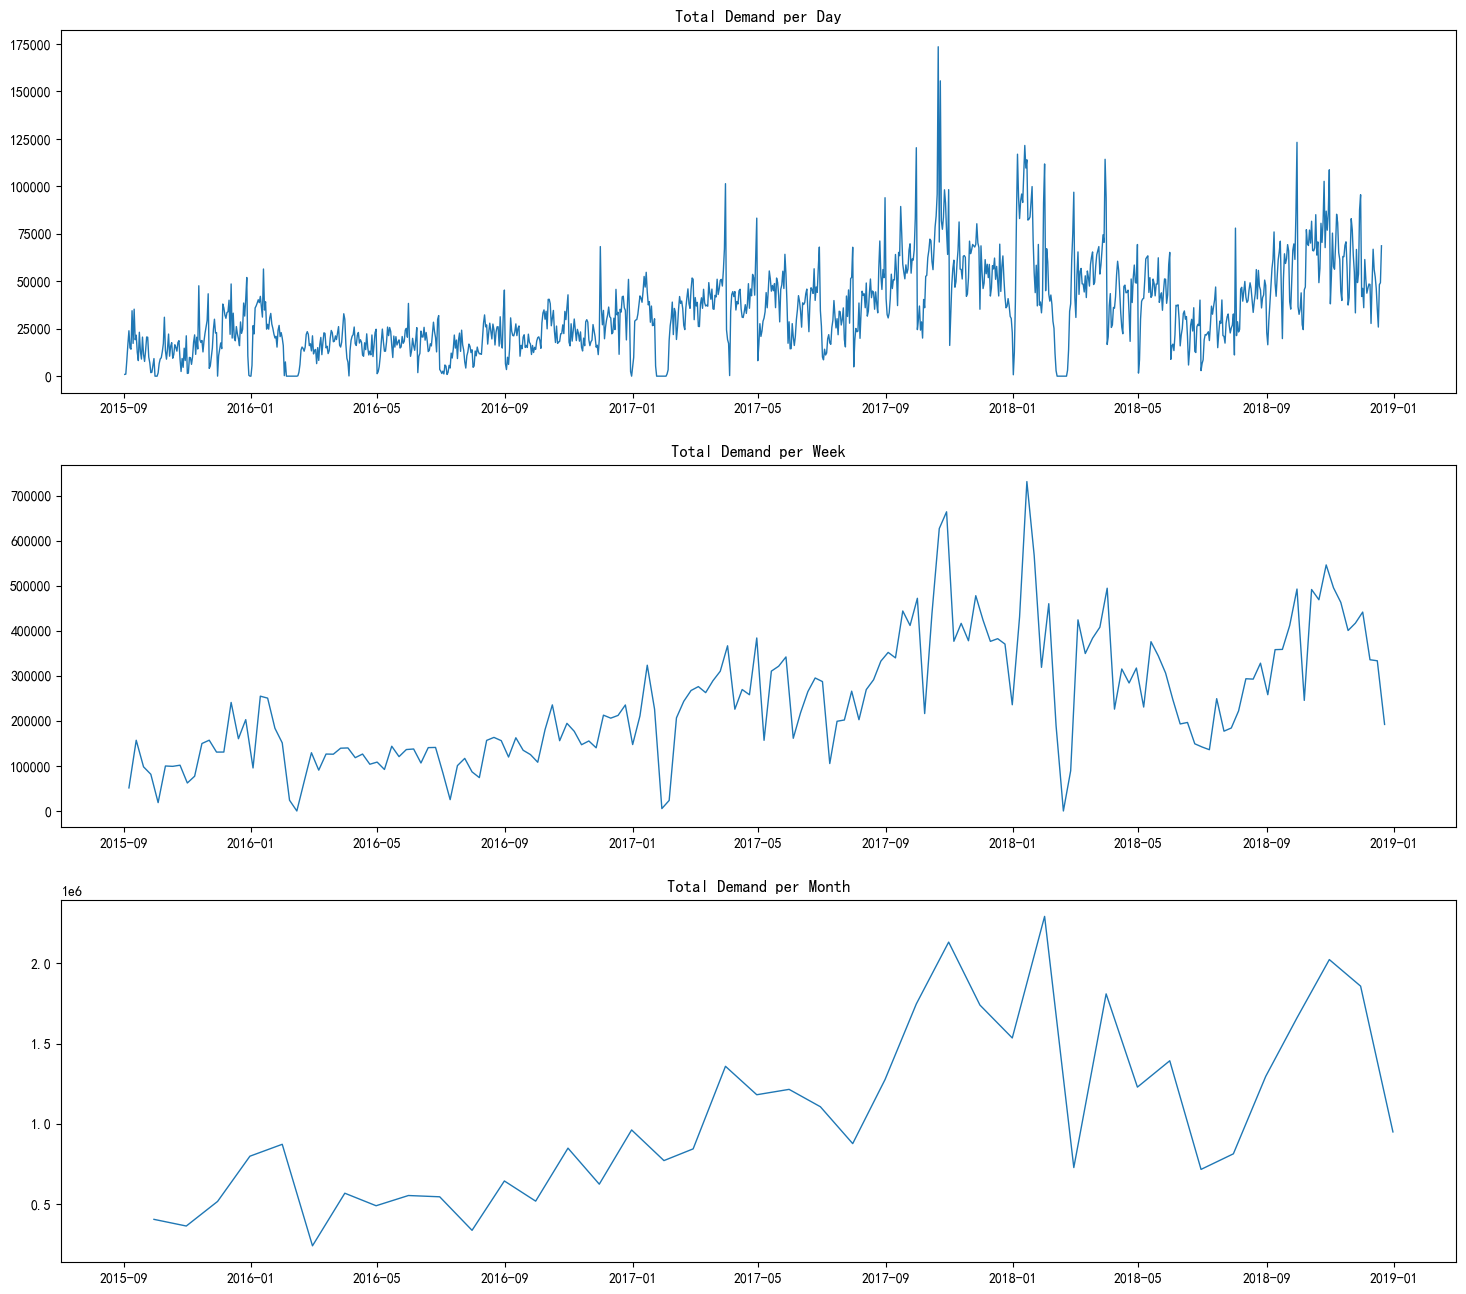

In [7]:
# Showing Demand in the timeframe of day, week, and month

fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.2)

ax1 = fig.add_subplot(3,1,1)
ax1.plot(data_without_outliers['ord_qty'].resample('D').sum(), linewidth=1)
ax1.set_title('Total Demand per Day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(3,1,2, sharex=ax1)
ax2.plot(data_without_outliers['ord_qty'].resample('W').sum(), linewidth=1)
ax2.set_title('Total Demand per Week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(3,1,3, sharex=ax1)
ax3.plot(data_without_outliers['ord_qty'].resample('ME').sum(), linewidth=1)
ax3.set_title('Total Demand per Month')
ax3.tick_params(axis='both', which='major')

plt.show()

##### The preprocessed data will be grouped by 'sales_region_code', 'item_code', 'first_cate_code', and 'second_cate_code'. The total demand will be resampled by day, week, and month. After that, rows with excessive zero values in the total demand will be removed. The cleaned data will be saved in three separate files: 'day.csv', 'week.csv', and 'month.csv', which will be used as the prediction datasets for daily, weekly, and monthly time granularities, respectively.

In [8]:
d = data_without_outliers.groupby(['sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code'])[
    'ord_qty'].resample('D').sum().reset_index()
d = d.loc[d['ord_qty'] != 0]
print(d)

w = data_without_outliers.groupby(['sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code'])[
    'ord_qty'].resample('W').sum().reset_index()
w = w.loc[w['ord_qty'] != 0]

m = data_without_outliers.groupby(['sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code'])[
    'ord_qty'].resample('ME').sum().reset_index()
m = m.loc[m['ord_qty'] != 0]

pd.DataFrame(d).to_csv(r"C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\day.csv", index=False)
pd.DataFrame(w).to_csv(r"C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\week.csv", index=False)
pd.DataFrame(m).to_csv(r"C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\month.csv", index=False)

         sales_region_code  item_code  first_cate_code  second_cate_code  \
0                      101      20002              303               406   
222                    101      20002              303               406   
224                    101      20002              303               406   
233                    101      20002              303               406   
239                    101      20002              303               406   
...                    ...        ...              ...               ...   
1040781                105      22084              302               408   
1040799                105      22084              302               408   
1040809                105      22084              302               408   
1040817                105      22084              302               408   
1040833                105      22084              302               408   

        order_date  ord_qty  
0       2017-08-04        4  
222     2018-03-14        2

##### Build Gradient Boosting Tree models:

##### For daily time granularity

In [9]:
df_day = pd.read_csv(r"C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\day.csv")
df_day

,sales_region_code,item_code,first_cate_code,second_cate_code,order_date,ord_qty
0,101,20002,303,406,2017-08-04,4
1,101,20002,303,406,2018-03-14,2
2,101,20002,303,406,2018-03-16,3
3,101,20002,303,406,2018-03-25,3
4,101,20002,303,406,2018-03-31,9
...,...,...,...,...,...,...
257033,105,22084,302,408,2018-08-25,10
257034,105,22084,302,408,2018-09-12,106
257035,105,22084,302,408,2018-09-22,5
257036,105,22084,302,408,2018-09-30,11


In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [11]:
# Data preprocessing
# Split training set and test set
X = df_day.drop('ord_qty', axis=1)
y = df_day['ord_qty']
c = y.mean()
d = y.std()

# Save c and d value
np.save(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\c.npy', c)
np.save(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\d.npy', d)

y = (y - c) / d

In [12]:
# For categorical data, use one-hot encoding for processing
X = pd.get_dummies(X, columns=['sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code'])
# Convert time-type variables into numeric variables
X['order_date'] = pd.to_datetime(X['order_date'])
X['year'] = X['order_date'].dt.year
X['month'] = X['order_date'].dt.month
X['quarter'] = X['order_date'].dt.quarter
X.drop('order_date', axis=1, inplace=True)

a = X.mean()
b = X.std()

# Save a and b values
np.save(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\a.npy', a)
np.save(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\b.npy', b)

X = (X - a) / b

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.08, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\tmp\model.pkl')

['C:\\Users\\Aaron\\Desktop\\Data Analysis and Demand Forecasting for Product Orders\\tmp\\model.pkl']

In [14]:
# Model evaluation
y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r_train = r2_score(y_train, y_pred_train)

y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r_test = r2_score(y_test, y_pred_test)

print('Training set mean squared error MSE:', mse_train)
print('Training set root mean squared error RMSE:', rmse_train)
print('Training set R2 score:', r_train)
print('Test set mean squared error MSE:', mse_test)
print('Test set root mean squared error RMSE:', rmse_test)
print('Test set R2 score:', r_test)

Training set mean squared error MSE: 0.7348886858188025
Training set root mean squared error RMSE: 0.8572564877671107
Training set R2 score: 0.2635732896957512
Test set mean squared error MSE: 0.7696178184442884
Test set root mean squared error RMSE: 0.8772786435587546
Test set R2 score: 0.23673295208984968


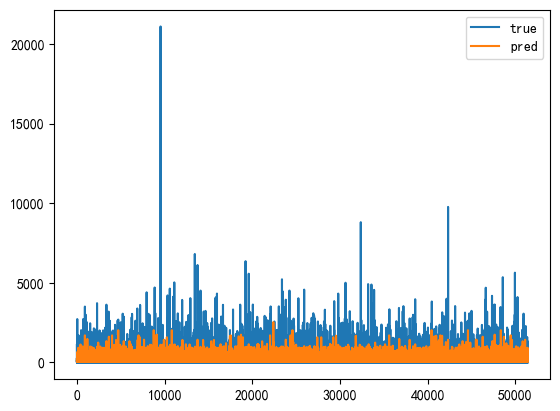

In [15]:
# Comparison chart of predicted values and true values for the test set

y_test = y_test * d + c
y_pred = y_pred_test * d + c
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()

##### For weekly time granularity

In [16]:
df_week = pd.read_csv(r"C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\week.csv")
df_week

,sales_region_code,item_code,first_cate_code,second_cate_code,order_date,ord_qty
0,101,20002,303,406,2017-08-06,4
1,101,20002,303,406,2018-03-18,5
2,101,20002,303,406,2018-03-25,3
3,101,20002,303,406,2018-04-01,9
4,101,20002,303,406,2018-04-08,7
...,...,...,...,...,...,...
90170,105,22084,302,408,2018-08-26,116
90171,105,22084,302,408,2018-09-16,106
90172,105,22084,302,408,2018-09-23,5
90173,105,22084,302,408,2018-09-30,11


In [17]:
# Data preprocessing
# Split the data into training and testing sets

X = df_week.drop('ord_qty', axis=1)
y = df_week['ord_qty']
c2 = y.mean()
d2 = y.std()

# Save c and d values
np.save(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\c2.npy', c2)
np.save(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\d2.npy', d2)
y = (y - c2) / d2

In [18]:
# For categorical data, use one-hot encoding
X = pd.get_dummies(X, columns=['sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code'])

# Convert time-related variables into numeric variables
X['order_date'] = pd.to_datetime(X['order_date'])
X['year'] = X['order_date'].dt.year
X['month'] = X['order_date'].dt.month
X['quarter'] = X['order_date'].dt.quarter
X.drop('order_date', axis=1, inplace=True)

a2 = X.mean()
b2 = X.std()

# Save a and b values to the specified path
np.save(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\a1.npy', a2)
np.save(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\b1.npy', b2)

X = (X - a2) / b2

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.08, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\model_week.pkl')

['C:\\Users\\Aaron\\Desktop\\Data Analysis and Demand Forecasting for Product Orders\\model_week.pkl']

In [20]:
# Model evaluation
y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r_train = r2_score(y_train, y_pred_train)

y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r_test = r2_score(y_test, y_pred_test)

print('Training set mean squared error MSE:', mse_train)
print('Training set root mean squared error RMSE:', rmse_train)
print('Training set R2 score:', r_train)
print('Test set mean squared error MSE:', mse_test)
print('Test set root mean squared error RMSE:', rmse_test)
print('Test set R2 score:', r_test)

Training set mean squared error MSE: 0.5167334272952524
Training set root mean squared error RMSE: 0.718841726178477
Training set R2 score: 0.47062099112933997
Test set mean squared error MSE: 0.6295915013392717
Test set root mean squared error RMSE: 0.7934680216236012
Test set R2 score: 0.42519792117552424


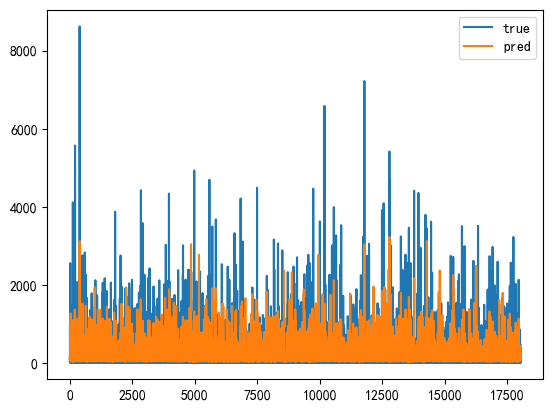

In [21]:
# Comparison chart of predicted values and true values for the test set

y_test = y_test * d + c
y_pred = y_pred_test * d + c
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()

##### For monthly time granularity

In [22]:
df = pd.read_csv(r"C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\month.csv")
df

,sales_region_code,item_code,first_cate_code,second_cate_code,order_date,ord_qty
0,101,20002,303,406,2017-08-31,4
1,101,20002,303,406,2018-03-31,17
2,101,20002,303,406,2018-04-30,124
3,101,20002,303,406,2018-05-31,110
4,101,20002,303,406,2018-06-30,77
...,...,...,...,...,...,...
30819,105,22084,302,408,2017-12-31,16
30820,105,22084,302,408,2018-01-31,17
30821,105,22084,302,408,2018-08-31,173
30822,105,22084,302,408,2018-09-30,122


In [23]:
# Data preprocessing
# Split the data into training and testing sets

X = df.drop('ord_qty', axis=1)
y = df['ord_qty']
c3 = y.mean()
d3 = y.std()

# Save c and d values
np.save(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\c1.npy', c3)
np.save(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\d1.npy', d3)
y = (y - c3) / d3

In [24]:
# For categorical data, use one-hot encoding
X = pd.get_dummies(X, columns=['sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code'])

# Convert time-related variables into numeric variables
X['order_date'] = pd.to_datetime(X['order_date'])
X['year'] = X['order_date'].dt.year
X['month'] = X['order_date'].dt.month
X['quarter'] = X['order_date'].dt.quarter
X.drop('order_date', axis=1, inplace=True)

a3 = X.mean()
b3 = X.std()

# Save a and b values to the specified path
np.save(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\a1.npy', a3)
np.save(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\b1.npy', b3)

X = (X - a3) / b3

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.08, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\model_month.pkl')

['C:\\Users\\Aaron\\Desktop\\Data Analysis and Demand Forecasting for Product Orders\\model_month.pkl']

In [26]:
# Model evaluation
y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r_train = r2_score(y_train, y_pred_train)

y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r_test = r2_score(y_test, y_pred_test)

print('Training set mean squared error MSE:', mse_train)
print('Training set root mean squared error RMSE:', rmse_train)
print('Training set R2 score:', r_train)
print('Test set mean squared error MSE:', mse_test)
print('Test set root mean squared error RMSE:', rmse_test)
print('Test set R2 score:', r_test)

Training set mean squared error MSE: 0.3238078735863478
Training set root mean squared error RMSE: 0.5690411879524608
Training set R2 score: 0.6913676251507997
Test set mean squared error MSE: 0.40153638374400513
Test set root mean squared error RMSE: 0.6336689859414023
Test set R2 score: 0.49983854868617916


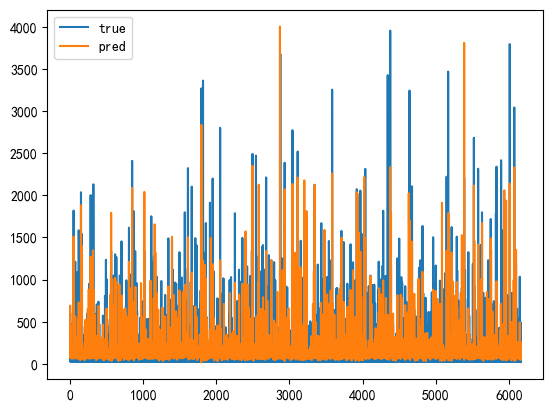

In [27]:
# Comparison chart of predicted values and true values for the test set

y_test = y_test * d + c
y_pred = y_pred_test * d + c
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()

##### The overall predictive performance of the built model is still poor. In terms of time granularity, predicting using monthly granularity gives the best results. For this model, further extraction of suitable time series features, grid search for parameter tuning, or the use of more complex models (such as deep learning models) can be considered for optimization

In [28]:
# Read the prediction data
pred_df = pd.read_csv(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\predict_sku1.csv', encoding='gbk')
df = pd.read_csv(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\month.csv', encoding='gbk')

# Select rows from pred_df where 'sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code' match with the same columns in df
pred1 = pred_df[pred_df[['sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code']].apply(tuple, axis=1).isin(df[['sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code']].apply(tuple, axis=1))]

# Select rows from pred_df that do not match the selected rows in pred1
no = pred_df.loc[~pred_df[['sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code']].apply(tuple, axis=1).isin(pred1[['sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code']].apply(tuple, axis=1))]

In [29]:
# For categorical data, use one-hot encoding
pred = pred1.copy()
pred = pd.get_dummies(pred, columns=['sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code'])

In [30]:
# Load a, b, c, and d values
a = np.load(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\a1.npy')
b = np.load(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\b1.npy')
c = np.load(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\c1.npy')
d = np.load(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\d1.npy')

In [31]:
# April
pred4 = pred.copy()
pred4['year'] = 2019
pred4['month'] = 4
pred4['quarter'] = 2
pred4 = (pred4 - a) / b

# May
pred5 = pred.copy()
pred5['year'] = 2019
pred5['month'] = 5
pred5['quarter'] = 2
pred5 = (pred5 - a) / b

# June
pred6 = pred.copy()
pred6['year'] = 2018
pred6['month'] = 6
pred6['quarter'] = 4
pred6 = (pred6 - a) / b

In [32]:
# Load the model
model = joblib.load(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\tmp\model_month.pkl')

In [33]:
# Predict demand for April
y_pred4 = model.predict(pred4)
y_pred4 = y_pred4 * d + c  # Adjust predictions with scaling factors
print('April Predicted Demand:\n', y_pred4)

# Predict demand for May
y_pred5 = model.predict(pred5)
y_pred5 = y_pred5 * d + c  # Adjust predictions with scaling factors

# Predict demand for June
y_pred6 = model.predict(pred6)
y_pred6 = y_pred6 * d + c  # Adjust predictions with scaling factors

April Predicted Demand:
 [399.07802768 646.041552   748.03332473 ... 682.8277281  779.00830241
 700.16161931]


In [34]:
# Save the prediction results to a file
result_df = pred1.copy()
result_df['Predicted Demand for April 2019'] = y_pred4
result_df['Predicted Demand for May 2019'] = y_pred5
result_df['Predicted Demand for June 2019'] = y_pred6

In [35]:
# Replace missing product codes with the mean values of predicted demand grouped by 'sales_region_code', 'first_cate_code', and 'second_cate_code'
final = result_df.groupby(['sales_region_code', 'first_cate_code', 'second_cate_code']).agg({
    'Predicted Demand for April 2019': 'mean',
    'Predicted Demand for May 2019': 'mean',
    'Predicted Demand for June 2019': 'mean'
}).reset_index()

# Merge the 'no' DataFrame with the 'buchong' DataFrame to fill in missing values
final = pd.merge(no, final, on=['sales_region_code', 'first_cate_code', 'second_cate_code'], how='left')

# Display the result
print(final)

     sales_region_code  item_code  first_cate_code  second_cate_code  \
0                  101      20011              303               401   
1                  101      20088              308               404   
2                  101      20114              306               407   
3                  101      20160              303               410   
4                  101      20165              305               412   
..                 ...        ...              ...               ...   
427                105      21964              303               410   
428                105      22004              303               401   
429                105      22008              308               404   
430                105      22009              306               407   
431                105      22075              307               403   

     Predicted Demand for April 2019  Predicted Demand for May 2019  \
0                         616.096452                     616.096

In [36]:
# Merge the DataFrames
result = pd.concat([result_df, final]).drop(['first_cate_code', 'second_cate_code'], axis=1)
result = result.round({'April 2019 Forecasted Demand': 0, 'May 2019 Forecasted Demand': 0, 'June 2019 Forecasted Demand': 0})
print(result)
result.to_excel(r'C:\Users\Aaron\Desktop\Data Analysis and Demand Forecasting for Product Orders\result.xlsx', index=False)

     sales_region_code  item_code  Predicted Demand for April 2019  \
0                  101      20002                       399.078028   
1                  101      20003                       646.041552   
2                  101      20006                       748.033325   
4                  101      20014                      1208.933016   
5                  101      20016                       539.693476   
..                 ...        ...                              ...   
427                105      21964                       300.057859   
428                105      22004                       685.767745   
429                105      22008                      1159.613855   
430                105      22009                      1108.975136   
431                105      22075                       977.163945   

     Predicted Demand for May 2019  Predicted Demand for June 2019  
0                       399.078028                      260.600215  
1                    